**Задача:**

$\begin{cases}
  \dfrac{dx}{dt} = x, \quad t \in (0, 1],\\
  x(0) = 1.
\end{cases}$

In [97]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Установка устройства для вычислений (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [98]:
# Определение области определения
t_min, t_max = 0.0, 1.0

# Количество точек внутри области и на границе
num_interior = 50   # Внутренние точки
num_boundary = 1     # Граничные точки

# Генерация сетки от x_min до x_max с количеством точек num_interior+num_boundary
# view(-1, 1) - транспонирует строку в столбец
# to(device) - переводит тензор в устройство device (нужно для вычислений на GPU)
t = torch.linspace(t_min, t_max, num_interior+num_boundary).view(-1, 1).to(device)

# Создание маски для внутренних точек
# Изначально все точки помечены как False (граничные)
mask = torch.zeros_like(t, dtype = bool)

# Маркирование внутренних точек
mask[num_boundary:] = True

# Внутренние точки
# view(-1, 1) - транспонирует строку в столбец
# requires_grad_(True) - т.к. на внутренних точках нужны будут вычисления градиентов
t_interior = t[mask].view(-1, 1).requires_grad_(True)

# Граничные точки
# view(-1, 1) - транспонирует строку в столбец
t_boundary = t[~mask].view(-1, 1)

In [99]:
# Определение нейронной сети
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Задаем архитектуру: 3 скрытых слоя по 20 нейронов с функцией активации Tanh
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

# Инициализация модели
model = PINN().to(device)

In [100]:
"""
dxdt = torch.autograd.grad(outputs=x, inputs=t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
d2xdt2 = torch.autograd.grad(outputs=dxdt, inputs=t, grad_outputs=torch.ones_like(dxdt), create_graph=True)[0]
F = torch.cos(omega * t)  # Внешняя сила
residual = d2xdt2 + omega**2 * x - F  # Резидуал уравнения
"""


# Определение функции потерь
def loss_function(t, t_0, lambda_bc=1.0):
    # Предсказания модели на внутренних точках
    x = model(t)

    # Вычисление производной dx/dt с помощью автоматического дифференцирования
    dx_dt = torch.autograd.grad(
        x, t,
        grad_outputs=torch.ones_like(x),
        create_graph=True
    )[0]

    d2x_dt2 = torch.autograd.grad(
        dx_dt, t,
        grad_outputs=torch.ones_like(x),
        create_graph=True
    )[0]
    
    # Частота
    omega = 2 * np.pi * 2

    # Внешняя сила
    F = torch.cos(omega * t)

    # Вычисление функции дифференциального уравнения на внутренних точках (residual)
    residual = d2x_dt2 + omega**2 * x - F

    # Предсказания модели на граничных точках
    xb_pred = model(t_0)

    # Граничные условия
    x_0 = torch.tensor([[1.0]], requires_grad=True).to(device)  # x(0) = 1
    v_0 = torch.tensor([[1.0]], requires_grad=True).to(device)  # v(0) = 1

    # Потери на уравнении (MSE по residual)
    loss_interior = torch.mean(residual**2)

    # Потери на граничных условиях (MSE между предсказанием и истинным значением)
    loss_boundary = torch.mean((xb_pred - x_0)**2)

    # Общая функция потерь с учетом коэффициента lambda_bc
    loss = loss_interior + lambda_bc * loss_boundary
    return loss

In [101]:
# Определение оптимизатора (Adam с шагом обучения lr = 1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Количество эпох обучения
num_epochs = 1000

# Список для хранения значений функции потерь
loss_history = []

# Цикл обучения с использованием tqdm
pbar = tqdm(range(num_epochs), desc='Training', ncols=80)
for epoch in pbar:
    optimizer.zero_grad()
    loss = loss_function(t_interior, t_boundary)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    # Обновление отображения tqdm
    pbar.set_postfix({'Loss': f'{loss.item():.2e}'})

Training:   0%|                         | 0/1000 [00:00<?, ?it/s, Loss=1.15e+03]

Training: 100%|█████████████| 1000/1000 [00:03<00:00, 300.14it/s, Loss=1.47e+00]


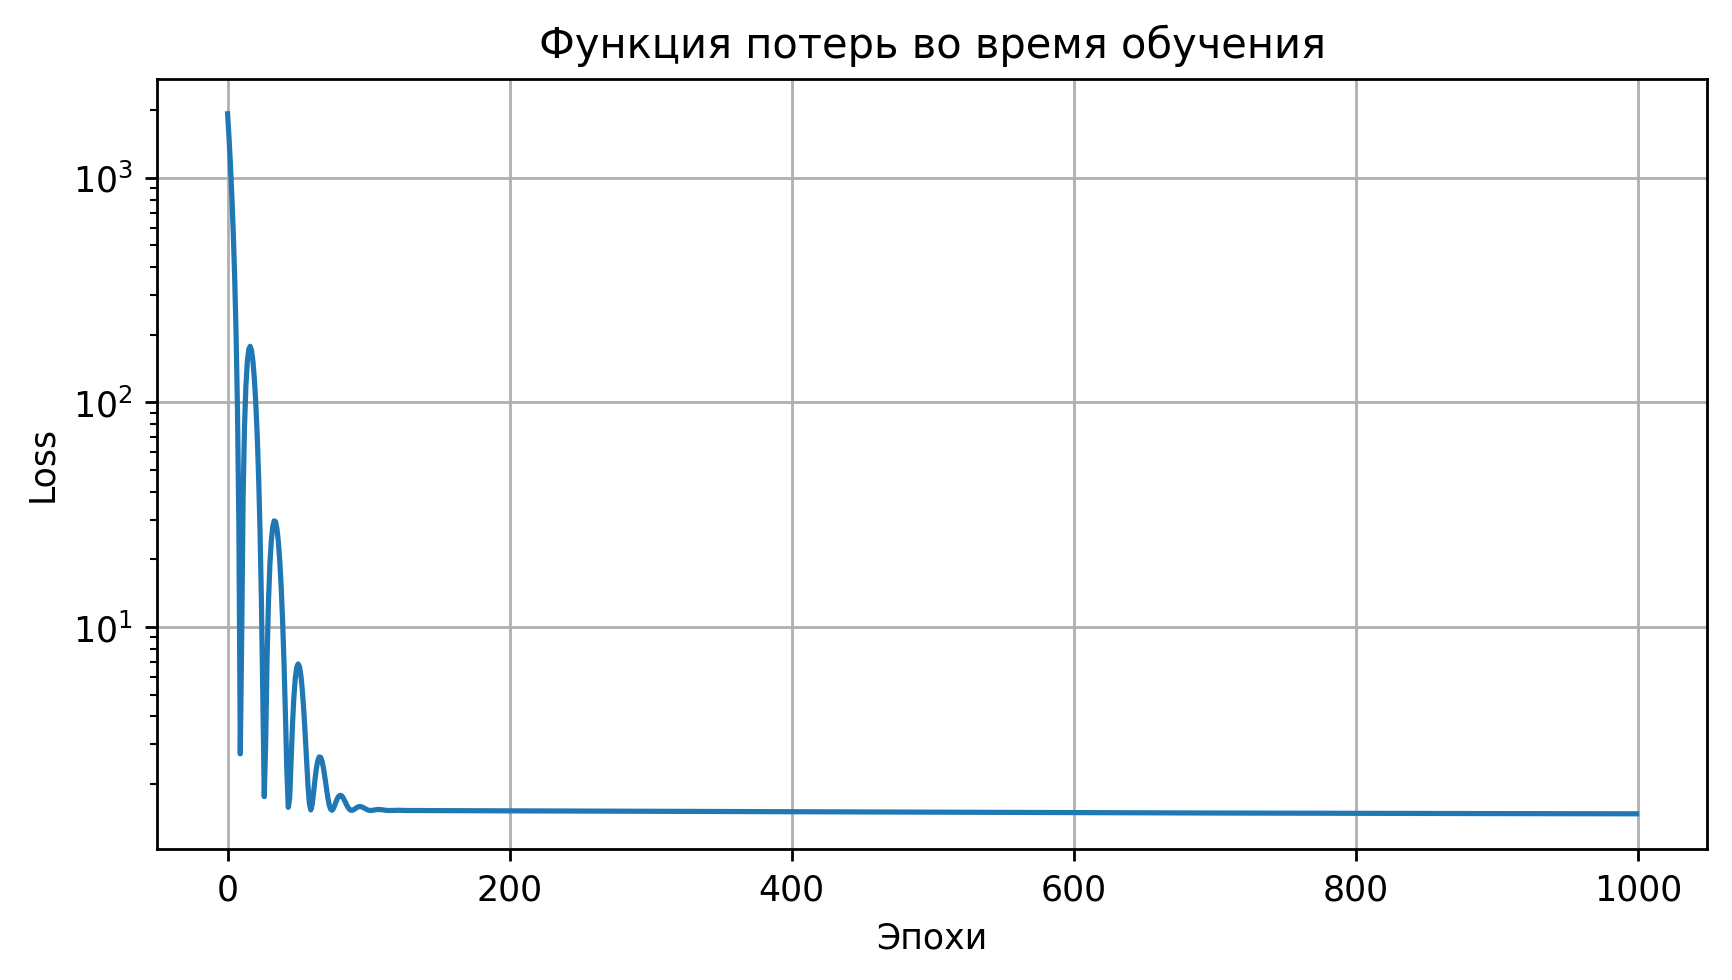

In [102]:
# Построение графика функции потерь в логарифмическом масштабе
plt.figure(figsize=(8, 4), dpi=250)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Функция потерь во время обучения')
plt.grid(True)
plt.show()

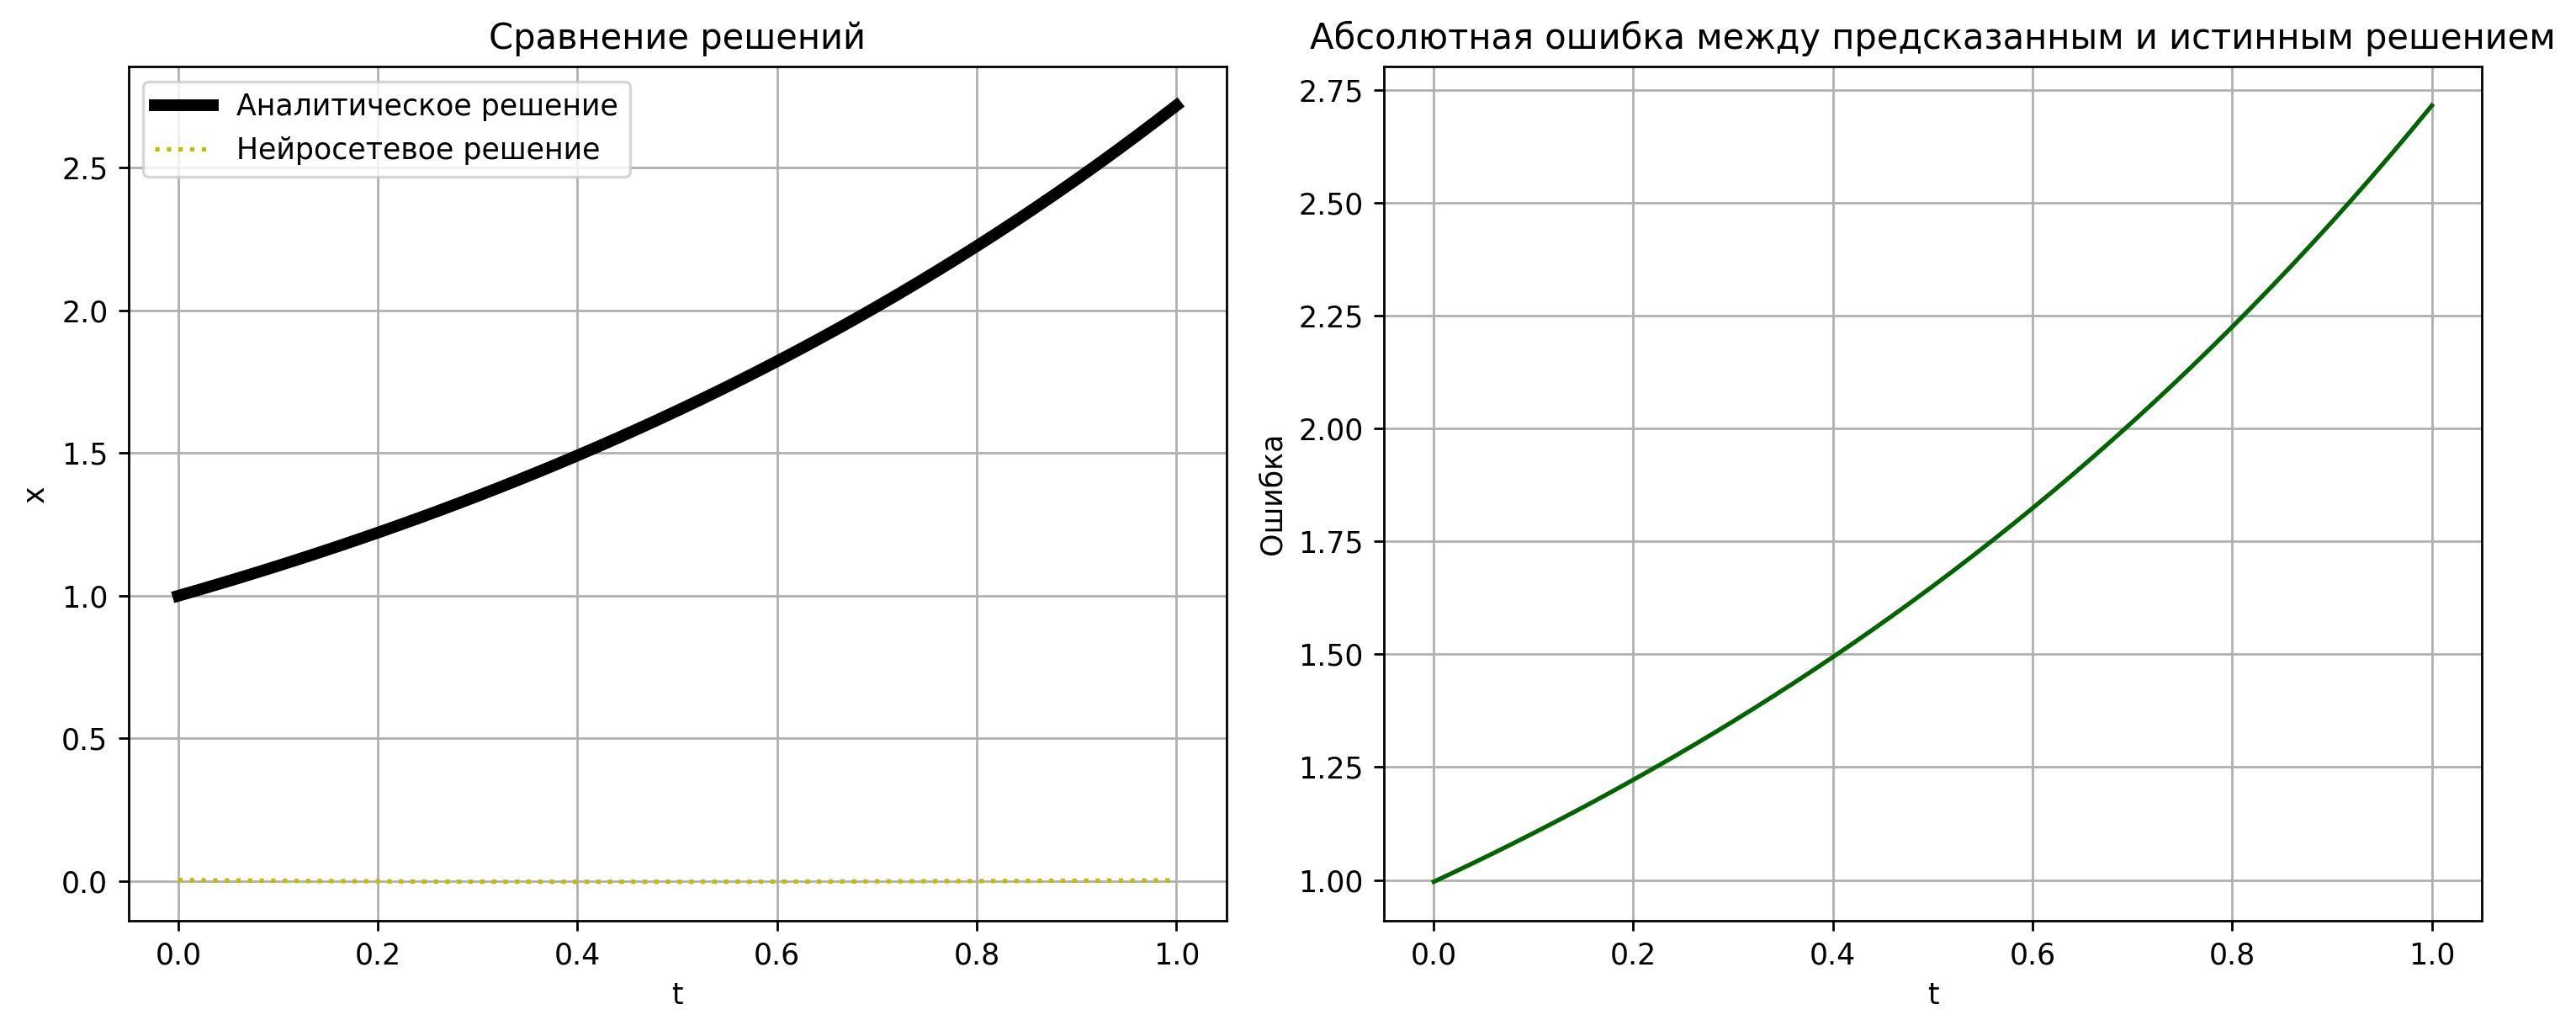

In [103]:
# Точки для визуализации решения и ошибки
t_plot = t.cpu().detach().numpy()

# Аналитическое решение
x_true = np.exp(t_plot)

# Предсказание решения моделью
x_pred = model(t).cpu().detach().numpy()

# Вычисление абсолютной ошибки
absolute_error = np.abs(x_true - x_pred)

# Построение графиков
plt.figure(figsize=(12, 5), dpi=250)

# График предсказанного и истинного решения
plt.subplot(1, 2, 1)
plt.plot(t_plot, x_true, label='Аналитическое решение', linewidth = 4, color='k')
plt.plot(t_plot, x_pred, 'y:', label='Нейросетевое решение')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Сравнение решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки
plt.subplot(1, 2, 2)
plt.plot(t_plot, absolute_error, color='darkgreen')
plt.xlabel('t')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между предсказанным и истинным решением')
plt.grid(True)

plt.tight_layout()
plt.show()